In [45]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import shap

In [46]:
df = pd.read_csv("gender_stats_preprocessed.csv")
display(df.shape)
df = df.dropna(axis=1)
display(df.shape)

(46, 403)

(46, 111)

In [47]:
x = df.drop(columns=['Country Name'], axis=0)
x = x.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled, columns=df.columns[1:], index=df['Country Name'])

In [48]:
df_scaled.shape

(46, 110)

In [49]:
train_data, test_data = train_test_split(df_scaled, random_state=43)

In [50]:
train_data

,A woman can apply for a passport in the same way as a man (1=yes; 0=no),A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can sign a contract in the same way as a man (1=yes; 0=no),A woman can travel outside the country in the same way as a man (1=yes; 0=no),A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),A woman can work in an industrial job in the same way as a man (1=yes; 0=no),A woman has the same rights to remarry as a man (1=yes; 0=no),Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no),"Death rate, crude (per 1,000 people)",Dismissal of pregnant workers is prohibited (1=yes; 0=no),...,"Women, Business and the Law: Marriage Indicator Score (scale 1-100)","Women, Business and the Law: Mobility Indicator Score (scale 1-100)","Women, Business and the Law: Parenthood Indicator Score (scale 1-100)","Women, Business and the Law: Pay Indicator Score (scale 1-100)","Women, Business and the Law: Pension Indicator Score (scale 1-100)","Women, Business and the Law: Workplace Indicator Score (scale 1-100)",Continent_Asia,Continent_Europe,Continent_North America,Continent_South America
Country Name,,,,,,,,,,,,,,,,,,,,,
Finland,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.306748,1.0,...,1.000000,1.0,0.8,1.000000,1.000000,1.0,0.0,1.0,0.0,0.0
Latvia,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.797546,1.0,...,1.000000,1.0,1.0,1.000000,1.000000,1.0,0.0,1.0,0.0,0.0
Ireland,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.073620,1.0,...,1.000000,1.0,1.0,1.000000,1.000000,1.0,0.0,1.0,0.0,0.0
Malta,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.159509,1.0,...,1.000000,1.0,0.6,0.666667,0.666667,1.0,0.0,1.0,0.0,0.0
Cyprus,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.113926,1.0,...,1.000000,1.0,0.8,0.666667,1.000000,1.0,0.0,1.0,0.0,0.0
Singapore,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.024540,0.0,...,1.000000,1.0,0.6,0.666667,0.666667,0.5,1.0,0.0,0.0,0.0
Czechia,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.484663,1.0,...,1.000000,1.0,1.0,1.000000,0.333333,1.0,0.0,1.0,0.0,0.0
Russian Federation,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.693252,1.0,...,0.666667,1.0,0.8,0.333333,0.333333,0.0,1.0,0.0,0.0,0.0
New Zealand,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.087730,1.0,...,1.000000,1.0,0.8,1.000000,1.000000,1.0,0.0,0.0,1.0,0.0


In [51]:
if "Poland" not in test_data.index:
    test_data.loc['Poland'] = train_data.loc['Poland']
    train_data.drop('Poland', inplace=True)

In [54]:
y_train = train_data['Fertility rate, total (births per woman)'].copy()
X_train = train_data.drop('Fertility rate, total (births per woman)', axis=1)

y_test = test_data['Fertility rate, total (births per woman)'].copy()
X_test = test_data.drop('Fertility rate, total (births per woman)', axis=1)

In [55]:
model = keras.Sequential([
    #normalizer,
    layers.Dense(14, activation='relu'),
    #layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))

In [56]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    verbose=0, epochs=100, batch_size = 5)

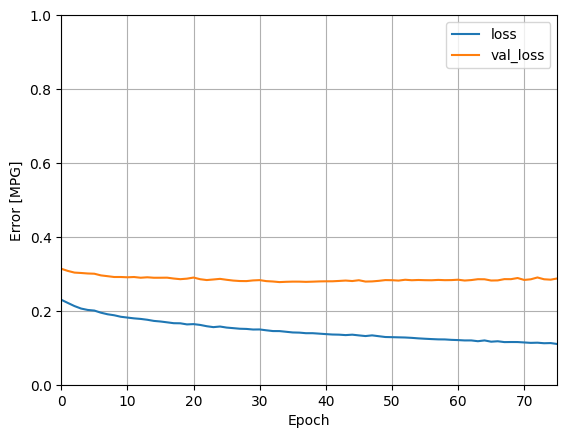

In [57]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlim([0,75])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [58]:
def model_builder(hp):
  model = keras.Sequential()
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 10-512
  hp_units = hp.Int('units', min_value=8, max_value=236, step=32)
  
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[tf.keras.metrics.MeanSquaredError()])

  return model

In [59]:
tuner = kt.Hyperband(model_builder,
                     objective='val_mean_squared_error',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [60]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [61]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

In [62]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
display(best_hps.get('units'))
display(best_hps.get('learning_rate'))

448

0.01

In [75]:
#model = tuner.hypermodel.build(best_hps)
model = keras.Sequential([
    layers.Dense(448, activation='relu'),
    layers.Dense(1)
  ])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss='mean_squared_error',
                metrics=[tf.keras.metrics.MeanSquaredError()])
history = model.fit(X_train, y_train, epochs=50, validation_split=0.4, verbose=0)

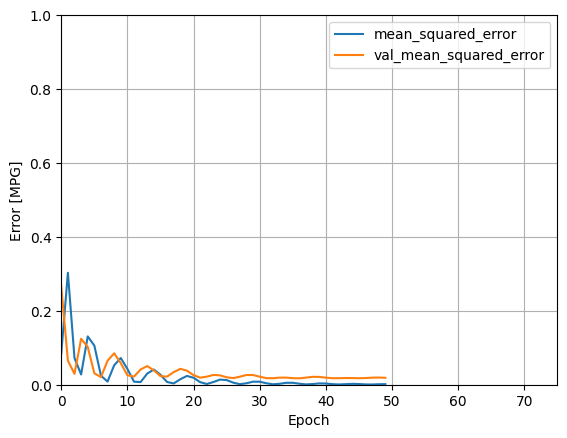

In [76]:
def plot_loss(history):
  plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
  plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
  plt.ylim([0, 1])
  plt.xlim([0,75])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [77]:
val_acc_per_epoch = history.history['val_mean_squared_error']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
best_epoch

37

In [78]:
model.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2, verbose=0)
eval_result = model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 36ms/step - loss: 0.0732 - mean_squared_error: 0.0732


In [79]:
from sklearn.metrics import mean_squared_error, make_scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) 
mse_scorer = make_scorer(rmse)

In [80]:
from sklearn.inspection import permutation_importance
results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring=mse_scorer)
importance = results.importances_mean

1/1 [==============================] - 0s 55ms/step


In [83]:
pd.DataFrame(importance, X.columns[1:]).sort_values([0], ascending=False).head(20)

,0
Paid leave is available to fathers (1=yes; 0=no),0.019247
A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),0.010300
"Employment in industry, female (% of female employment) (modeled ILO estimate)",0.008102
A woman can work in an industrial job in the same way as a man (1=yes; 0=no),0.006839
There is paid parental leave (1=yes; 0=no),0.006642
The government administers 100% of maternity leave benefits (1=yes; 0=no),0.005913
"Women, Business and the Law: Marriage Indicator Score (scale 1-100)",0.004720
The mandatory retirement age for men and women is the same (1=yes; 0=no),0.004712
"Employment in industry, male (% of male employment) (modeled ILO estimate)",0.004370
"Self-employed, male (% of male employment) (modeled ILO estimate)",0.004060


In [98]:
X_train

,A woman can apply for a passport in the same way as a man (1=yes; 0=no),A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can sign a contract in the same way as a man (1=yes; 0=no),A woman can travel outside the country in the same way as a man (1=yes; 0=no),A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),A woman can work in an industrial job in the same way as a man (1=yes; 0=no),A woman has the same rights to remarry as a man (1=yes; 0=no),Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no),"Death rate, crude (per 1,000 people)",Dismissal of pregnant workers is prohibited (1=yes; 0=no),...,"Women, Business and the Law: Marriage Indicator Score (scale 1-100)","Women, Business and the Law: Mobility Indicator Score (scale 1-100)","Women, Business and the Law: Parenthood Indicator Score (scale 1-100)","Women, Business and the Law: Pay Indicator Score (scale 1-100)","Women, Business and the Law: Pension Indicator Score (scale 1-100)","Women, Business and the Law: Workplace Indicator Score (scale 1-100)",Continent_Asia,Continent_Europe,Continent_North America,Continent_South America
Country Name,,,,,,,,,,,,,,,,,,,,,
Finland,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.306748,1.0,...,1.000000,1.0,0.8,1.000000,1.000000,1.0,0.0,1.0,0.0,0.0
Latvia,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.797546,1.0,...,1.000000,1.0,1.0,1.000000,1.000000,1.0,0.0,1.0,0.0,0.0
Ireland,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.073620,1.0,...,1.000000,1.0,1.0,1.000000,1.000000,1.0,0.0,1.0,0.0,0.0
Malta,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.159509,1.0,...,1.000000,1.0,0.6,0.666667,0.666667,1.0,0.0,1.0,0.0,0.0
Cyprus,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.113926,1.0,...,1.000000,1.0,0.8,0.666667,1.000000,1.0,0.0,1.0,0.0,0.0
Singapore,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.024540,0.0,...,1.000000,1.0,0.6,0.666667,0.666667,0.5,1.0,0.0,0.0,0.0
Czechia,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.484663,1.0,...,1.000000,1.0,1.0,1.000000,0.333333,1.0,0.0,1.0,0.0,0.0
Russian Federation,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.693252,1.0,...,0.666667,1.0,0.8,0.333333,0.333333,0.0,1.0,0.0,0.0,0.0
New Zealand,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.087730,1.0,...,1.000000,1.0,0.8,1.000000,1.000000,1.0,0.0,0.0,1.0,0.0


In [97]:
X_test

,A woman can apply for a passport in the same way as a man (1=yes; 0=no),A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can sign a contract in the same way as a man (1=yes; 0=no),A woman can travel outside the country in the same way as a man (1=yes; 0=no),A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),A woman can work in an industrial job in the same way as a man (1=yes; 0=no),A woman has the same rights to remarry as a man (1=yes; 0=no),Criminal penalties or civil remedies exist for sexual harassment in employment (1=yes; 0=no),"Death rate, crude (per 1,000 people)",Dismissal of pregnant workers is prohibited (1=yes; 0=no),...,"Women, Business and the Law: Marriage Indicator Score (scale 1-100)","Women, Business and the Law: Mobility Indicator Score (scale 1-100)","Women, Business and the Law: Parenthood Indicator Score (scale 1-100)","Women, Business and the Law: Pay Indicator Score (scale 1-100)","Women, Business and the Law: Pension Indicator Score (scale 1-100)","Women, Business and the Law: Workplace Indicator Score (scale 1-100)",Continent_Asia,Continent_Europe,Continent_North America,Continent_South America
Country Name,,,,,,,,,,,,,,,,,,,,,
Mexico,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.245767,1.0,...,1.000000,1.0,0.6,0.666667,0.666667,1.0,0.0,0.0,0.0,1.0
Norway,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.147239,1.0,...,1.000000,1.0,1.0,1.000000,1.000000,1.0,0.0,1.0,0.0,0.0
Israel,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.000000,1.0,...,0.333333,1.0,0.6,0.333333,0.666667,1.0,1.0,0.0,0.0,0.0
Spain,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.251534,1.0,...,1.000000,1.0,1.0,1.000000,1.000000,1.0,0.0,1.0,0.0,0.0
China,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.109202,1.0,...,1.000000,1.0,0.8,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0
Canada,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.147239,1.0,...,1.000000,1.0,1.0,1.000000,1.000000,1.0,0.0,0.0,1.0,0.0
France,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.263804,1.0,...,1.000000,1.0,1.0,1.000000,1.000000,1.0,0.0,1.0,0.0,0.0
Hungary,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.656442,1.0,...,1.000000,1.0,1.0,0.666667,1.000000,1.0,0.0,1.0,0.0,0.0
Japan,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.386503,1.0,...,0.666667,1.0,1.0,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0


In [84]:
explainer = shap.DeepExplainer(model, X_train.values)
shap_values = explainer.shap_values(X_test.values)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


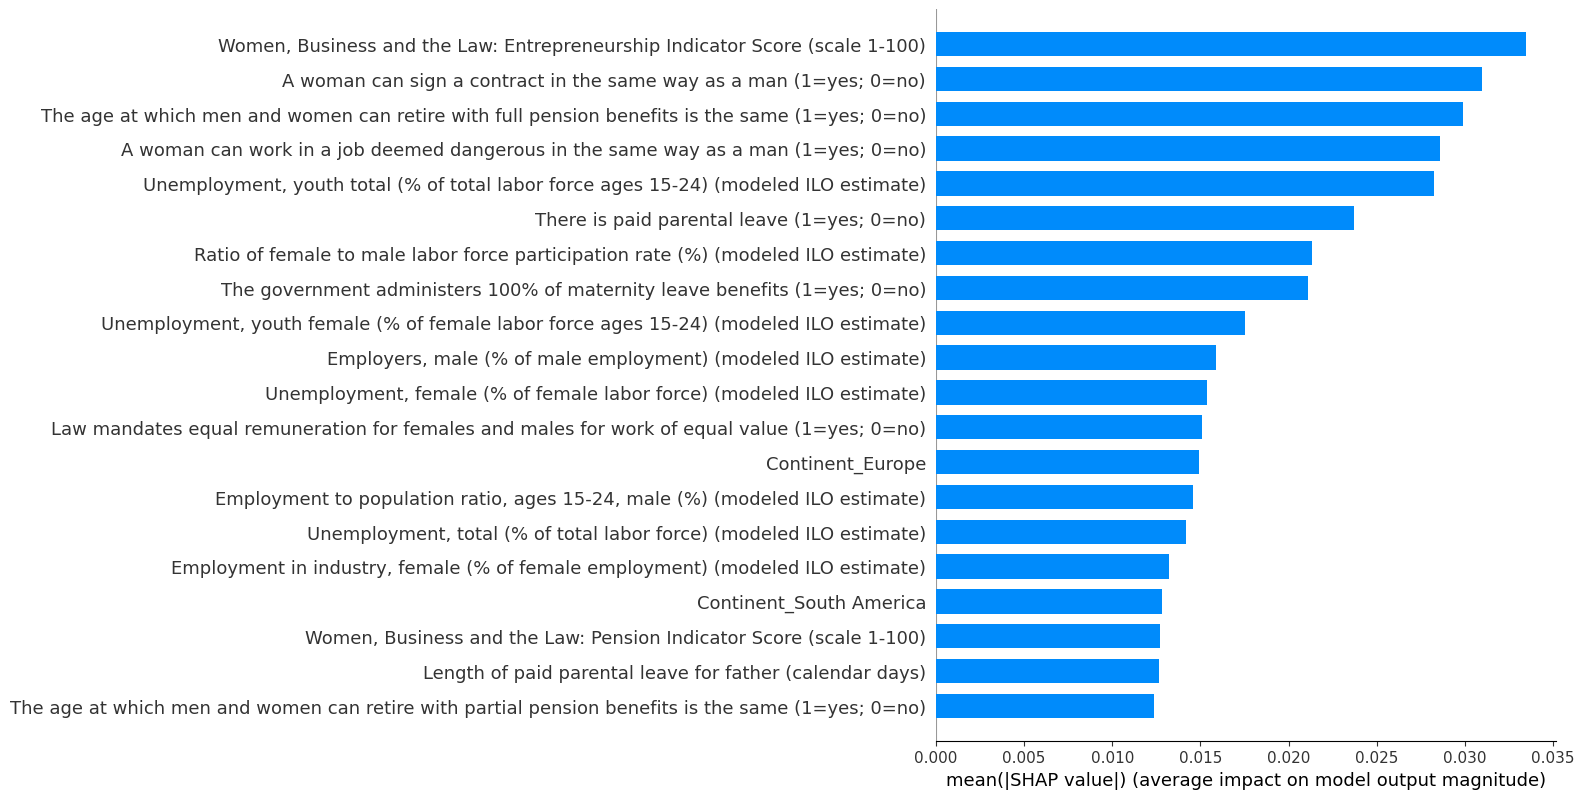

In [100]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns)

In [101]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = X_test.columns)

In [103]:
X_test.loc[12,:]

A woman can apply for a passport in the same way as a man (1=yes; 0=no)              1.0
A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no)      1.0
A woman can sign a contract in the same way as a man (1=yes; 0=no)                   1.0
A woman can travel outside the country in the same way as a man (1=yes; 0=no)        1.0
A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no)    1.0
                                                                                    ... 
Women, Business and the Law: Workplace Indicator Score (scale 1-100)                 1.0
Continent_Asia                                                                       0.0
Continent_Europe                                                                     1.0
Continent_North America                                                              0.0
Continent_South America                                                              0.0
Name: Poland, Length:

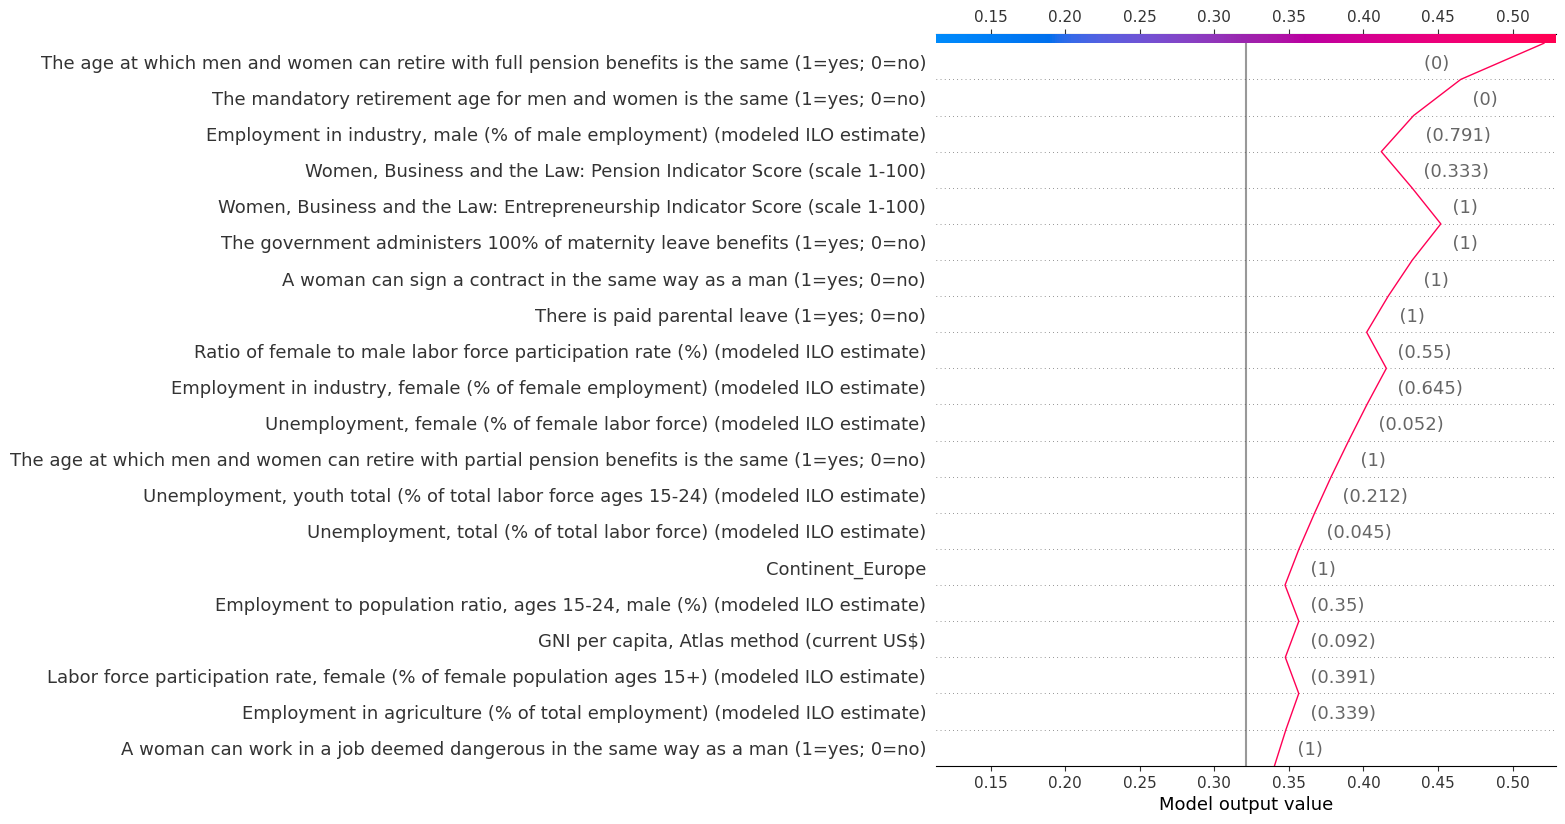

In [105]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][12], features = X_test.iloc[12,:], feature_names = X_test.columns.tolist())

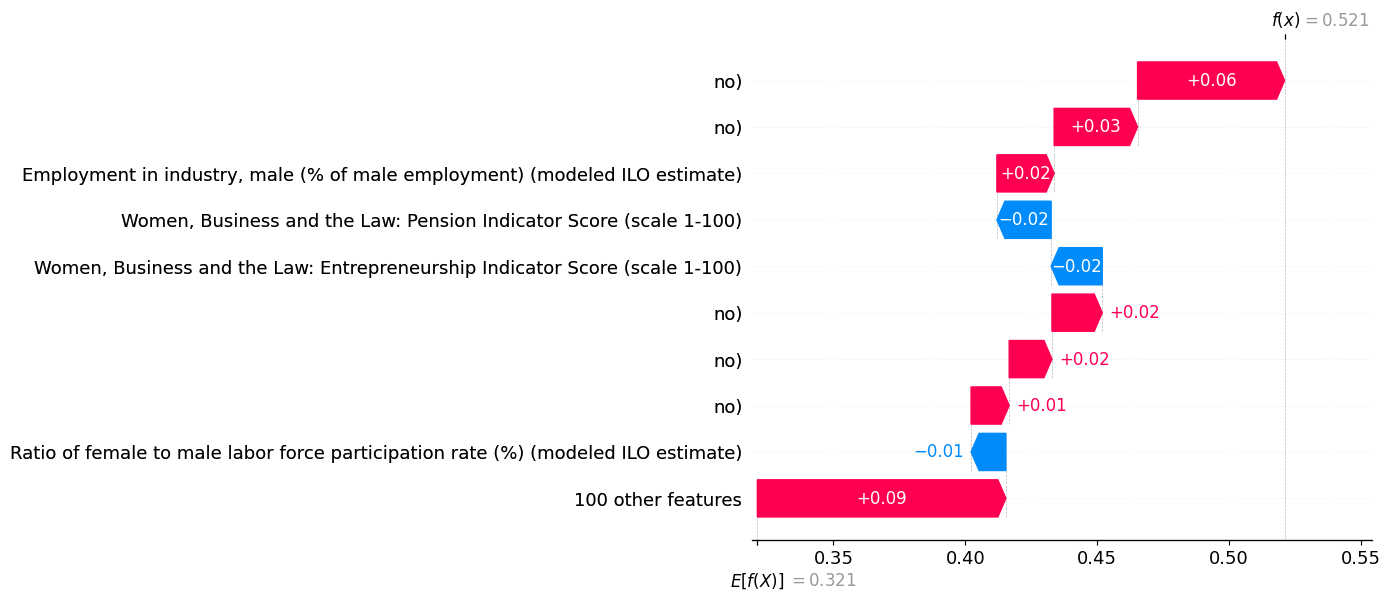

In [106]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][12], feature_names = X_test.columns)